In [ ]:
!pip install tensorflow

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
import numpy as np
import os
import shutil
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [12]:
dataset_path = "/content/gdrive/MyDrive/dataset_blood"
dataset_path

'/content/gdrive/MyDrive/dataset_blood'

In [13]:
Batch_size = 32

In [14]:
dataset = image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='int',
    image_size=(64, 64),
    batch_size=32
)


Found 8040 files belonging to 2 classes.


In [16]:
from collections import Counter

class_names = dataset.class_names
class_counts = Counter()

for _, labels in dataset.unbatch():
    class_counts[int(labels.numpy())] += 1

print("Class Distribution:")
for i, count in class_counts.items():
    print(f"{class_names[i]}: {count}")


Class Distribution:
dataset: 8040


In [17]:
def plot_class_distribution(class_names, class_counts):
    counts = [class_counts[i] for i in range(len(class_names))]

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, counts, color='skyblue')
    plt.xlabel('Class Names')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


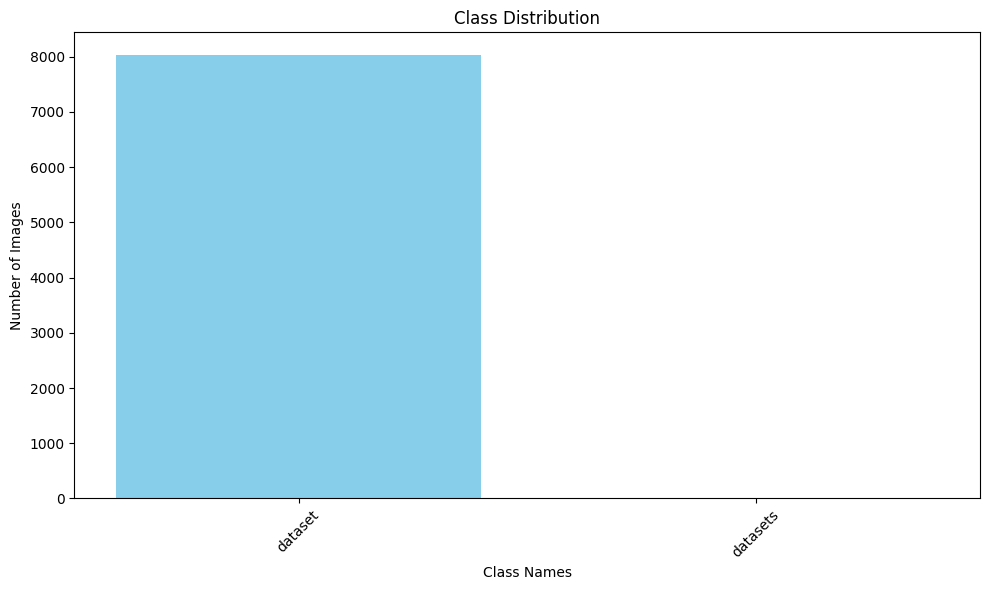

In [18]:
plot_class_distribution(class_names, class_counts)

In [19]:
max_count = max (class_counts.values())

In [20]:
def oversample_class(class_id, count, max_count):
  unbatched_dataset = dataset.unbatch()

  class_dataset = unbatched_dataset.filter(lambda img, lbl: tf.equal(lbl, class_id))
  repeat_factor =max_count // count + (max_count % count > 0)
  return class_dataset.repeat(repeat_factor).take(max_count)


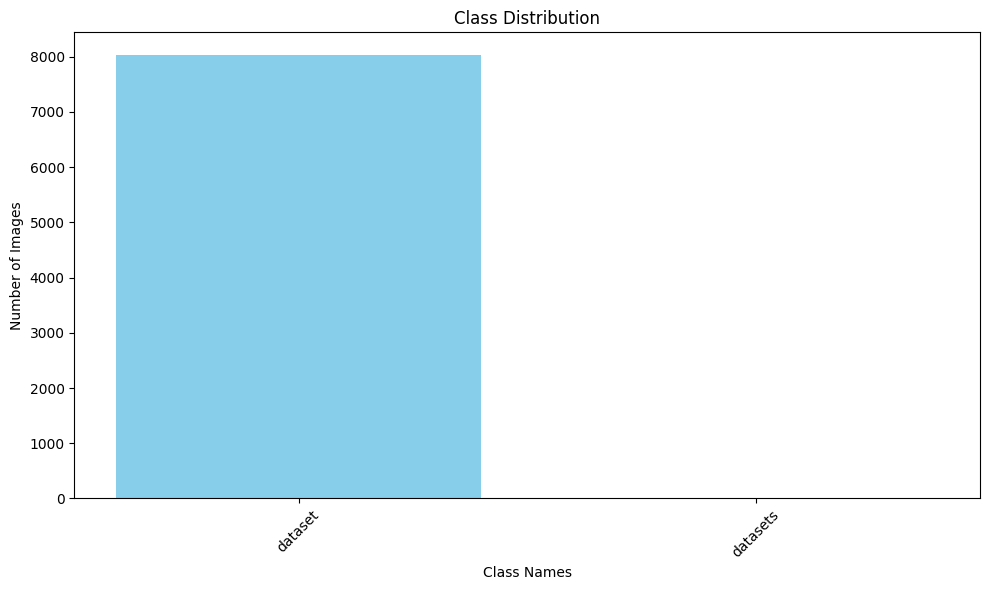

In [21]:
balance_datasets = []
for class_id, count in class_counts.items():
  balance_datasets.append(oversample_class(class_id, count, max_count))

balanced_dataset = tf.data.Dataset.sample_from_datasets(balance_datasets)

balanced_class_counts =Counter([int(lbl.numpy()) for _, lbl in balanced_dataset])
plot_class_distribution(class_names, balanced_class_counts)

balanced_dataset = balanced_dataset.batch(Batch_size,drop_remainder=True)

In [22]:
for sample in balanced_dataset.take(10):
  print(sample[0].shape)

(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)


In [31]:
balance_dataset_unbatched  = balanced_dataset.unbatch()
data_size = sum(1 for _ in balance_dataset_unbatched)
print(f"Total dataset size: {data_size}")

Total dataset size: 8032


In [ ]:
balance_dataset_unbatched = balanced_dataset.unbatch()

train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)


train_dataset = balanced_dataset_unbatched.take(train_size)
val_test_dataset = balanced_dataset_unbatched.skip(train_size)
val_dataset = val_test_dataset.take(val_size)
test_dataset = val_test_dataset.skip(val_size)

train_dataset = train_dataset.batch(Batch_size, drop_remainder=True)
val_dataset = val_dataset.batch(Batch_size, drop_remainder=True)
test_dataset = test_dataset.batch(Batch_size, drop_remainder=True)

train_batch_count = sum(1 for _ in train_dataset)
val_batch_count = sum(1 for _ in val_dataset)
test_batch_count = sum(1 for _ in test_dataset)

print(f"Train Batch Count: {train_batch_count * Batch_size}")
print(f"Validation Batch Count: {val_batch_count * Batch_size}")
print(f"Test Batch Count: {test_batch_count * Batch_size}")

In [34]:
# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Unbatch the balanced dataset
balance_dataset_unbatched = balanced_dataset.unbatch()

# Calculate dataset size
dataset_size = sum(1 for _ in balance_dataset_unbatched)

# Re-unbatch to start again (as iterators are exhausted after one full pass)
balance_dataset_unbatched = balanced_dataset.unbatch()

# Calculate sizes
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)

# Split dataset
train_dataset = balance_dataset_unbatched.take(train_size)
val_test_dataset = balance_dataset_unbatched.skip(train_size)
val_dataset = val_test_dataset.take(val_size)
test_dataset = val_test_dataset.skip(val_size)

# Batch the datasets
train_dataset = train_dataset.batch(Batch_size, drop_remainder=True)
val_dataset = val_dataset.batch(Batch_size, drop_remainder=True)
test_dataset = test_dataset.batch(Batch_size, drop_remainder=True)

# Count batches
train_batch_count = sum(1 for _ in train_dataset)
val_batch_count = sum(1 for _ in val_dataset)
test_batch_count = sum(1 for _ in test_dataset)

# Print batch counts (multiply by batch size to get sample count)
print(f"Train Sample Count: {train_batch_count * Batch_size}")
print(f"Validation Sample Count: {val_batch_count * Batch_size}")
print(f"Test Sample Count: {test_batch_count * Batch_size}")


Train Sample Count: 5600
Validation Sample Count: 1184
Test Sample Count: 1184


In [50]:
import tensorflow as tf

def create_high_accuracy_model(class_names):
    model = tf.keras.models.Sequential([

        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


# Make sure you have this list defined earlier
# For example:
# class_names = ['cat', 'dog', 'elephant']  # Your actual classes

# Now create the model
high_accuracy_model = create_high_accuracy_model(class_names)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [55]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
    )

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
    )

In [56]:
#train the model

history_high_acc = high_accuracy_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/50
    175/Unknown 106s 574ms/step - accuracy: 0.9744 - loss: 4.4679

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


175/175 ━━━━━━━━━━━━━━━━━━━━ 130s 713ms/step - accuracy: 0.9744 - loss: 4.4469 - val_accuracy: 0.9737 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 125s 712ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.9737 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 130s 745ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.9737 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
175/175 ━━━━━━━━━━━━━━━━━━━━ 123s 700ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.9737 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 145s 720ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.9737 - val_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 6/50
175/175 ━━━━━━━━━━━━━━━

In [61]:
 # Evaluate the model on validation data
high_acc_eval =high_accuracy_model.evaluate(val_dataset)
print(f"High accuracy Model - Loss: {high_acc_eval[0]}, Accuracy: {high_acc_eval[1]}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 173ms/step - accuracy: 0.9993 - loss: 0.0000e+00
High accuracy Model - Loss: 0.0, Accuracy: 0.9736841917037964


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [62]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()


  plot_accuracy(history_high_acc)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

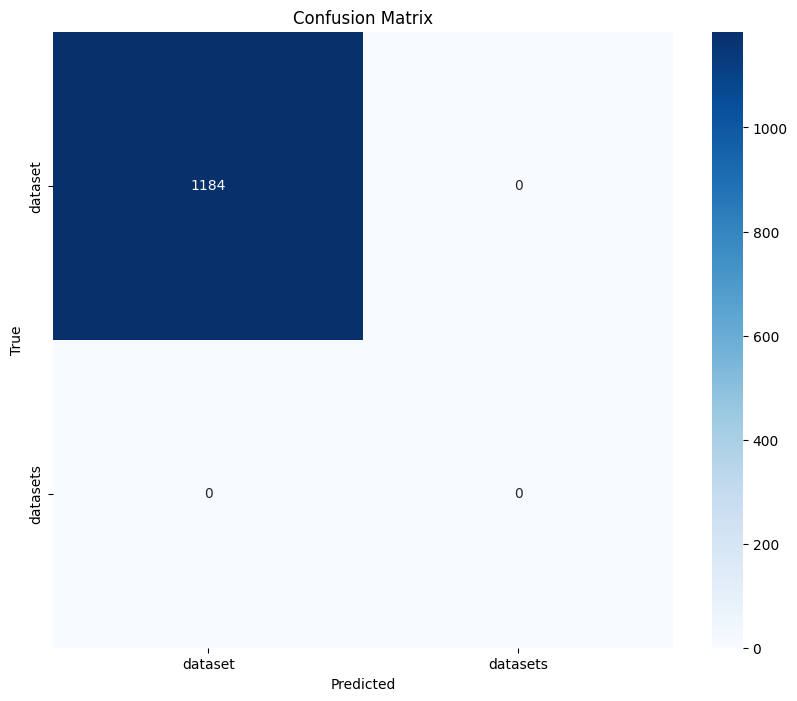

In [67]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = high_accuracy_model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels)

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Create the classification report
report = classification_report(
    y_true,
    y_pred,
    labels=list(range(len(class_names))),  # Add this line
    target_names=class_names
)
print("Classification report:")
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(
    y_true,
    y_pred,
    labels=list(range(len(class_names)))   # Ensure all classes are represented
)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [69]:
high_accuracy_model.save('/content/gdrive/MyDrive/high_accuracy_model.h5')
print("Model saved as HDF5 format.")

Model saved as HDF5 format.


In [70]:
pip show pillow

Name: pillow
Version: 11.1.0
Summary: Python Imaging Library (Fork)
Home-page: https://python-pillow.github.io
Author: 
Author-email: "Jeffrey A. Clark" <aclark@aclark.net>
License: MIT-CMU
Location: /usr/local/lib/python3.11/dist-packages
Requires: 
Required-by: bokeh, diffusers, dopamine_rl, fastai, imageio, matplotlib, scikit-image, sentence-transformers, torchvision, wordcloud
